In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
# 0-9 label
num_classes = 10
# pixel 28*28*1
input_shape = (28,28,1)

**data load 진행**

In [ ]:
# set train, test data
(x_train,y_train),(x_test,y_test) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# scale images to the [0,1] range
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255

# make sure images have shape (28,28,1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples") # 60000 개
print(x_train.shape[0], "test samples") # 60000 개

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test,num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
60000 test samples


**model 구성 변경요소**

model의 구성은 강의 노트의 X,O를 구분하는 모델의 구성을 참조하여 kernel size 3 * 3으로 설정하고 출력 공간의 차원을 결정하는 filter를 32로 설정, 활성화 함수는 relu  함수로 설정하여 합성곱층을 두번 쌓고, 2 * 2 사이즈의 특정 영역에서 가장 큰 값을 샘플링하는 풀링 방식인 maxpooling으로 Feature map으로부터 값을 샘플링해서 압축하는 과정을 거친다. 이후, 다시 위와 같은 합성곱층 한번, maxpooling층을 한번 쌓는 구성을 진행하였다.

또한, Flatten layer를 통해 위의 layer들을 거쳐 나온 2차원 data를 1차원으로 압축시켜 주었다. 그 후, 각각 relu 활성화 함수와 softmax 함수를 사용한 dense layer로 이전 계층의 모든 뉴런과 결합된 형태의 layer 즉, fully-connected layer의 역할을 진행하도록 하였다.

이때, relu 활성화 함수와, softmax 활성화 함수의 차이는 relu 함수는 입력값이 양수 일때는 x 이고 음수 일대는 0을 출력하기 때문에 훈련능력이 감소하지만 학습이 빠른 반면, softmax 함수는 입력 받은  값을 0-1 사이의 출력이 되도록 정규화 하여 출력 값들의 항상 1이 되도록 한다. 따라서 마지막의 출력 layer에서는 가장 높은 값을 가진 0-9까지의 classes를 출력하기 위해서 softmax 함수를 활성화 함수로 두었다.



In [ ]:
model = keras.Sequential(
    [
     keras.Input(shape = input_shape), # image input
     layers.Conv2D(32, kernel_size=(3,3), activation = "relu"), #32개 3*3 필터를 생성
     layers.Conv2D(32, kernel_size=(3,3), activation = "relu"),
     layers.MaxPooling2D(pool_size=(2,2)),
     
     layers.Conv2D(32, kernel_size=(3,3), activation = "relu"),
     layers.MaxPooling2D(pool_size=(2,2)),

     layers.Flatten(),
     layers.Dropout(0.5),
     layers.Dense(64, activation='relu'),
     layers.Dense(num_classes, activation = "softmax"),
    ]
)

**compile param 변경요소**

batch sized는 64로 줄여 64개의 데이터와 실제 레이블 값과 비교하도록 진행하였다. 이를 통해, 학습이 조금씩 이루어져 가중치를 업데이트 하는 과정이 오래 걸리지만 앞에서는 오답으로 인식하더라도 후에는 정답으로 인식할 가능성을 높였다.

epoch는 30으로 증가시켜 학습을 더 많이 진행하도록 하였다. 이를 통해서 모델이 더 정답 label을 잘 출력할 수도 있지만, overfitting이 발생하여 학습셋에 대한 성능만 증가하고 테스트 셋에 대한 성능이 저하될 가능성이 있다. 하지만 아래에서 볼 수 있듯이 30 정도의 epoch은 ovefitting이 일어 나지 않아 성능이 15로 진행했을 때보다 높아진 것을 관찰할 수 있다.

손실 함수를 categorical_crossentropy로 그대로 설정하였는데, 이는 클래스가 여러개(0-9)이기 때문이다.(앞서 softmax 활성화함수를 사용한 이유와 같다.) 결과도 one-hot encoding으로 결과가 출력된다.

optimizer는 SGD로 설정하였는데 기존의 adam으로 설정했을 때보다 더 헤매면서 학습을 진행하는 것을 볼 수 있다.따라서 SGD는 연산량이 많다.
또한, 같은 15 epoch로 학습을 진행했을때, 98%의 더 낮은 성능을 보여준다.
반면, adam은 momentum과 이전의 gradient을 모두 고려하여 학습을 진행하여 학습방향과 스텝을 적절하게 진행한다.

위와 같은 이유로, optimizer를 SGD로 변경하여 진행해보는 대신 batch 사이즈를 줄이고, epoch 크기를 증가하여 더 촘촘히 학습을 진행하도록 하였다.

In [ ]:
batch_size = 64
epochs = 30

model.compile(loss = "categorical_crossentropy",
              optimizer = "SGD",
              metrics = ["accuracy"])

history = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_split = 0.1)

Epoch 1/30
844/844 [==============================] - 8s 9ms/step - loss: 0.0450 - accuracy: 0.9855 - val_loss: 0.0301 - val_accuracy: 0.9915
Epoch 2/30
844/844 [==============================] - 7s 9ms/step - loss: 0.0446 - accuracy: 0.9858 - val_loss: 0.0279 - val_accuracy: 0.9925
Epoch 3/30
844/844 [==============================] - 7s 8ms/step - loss: 0.0442 - accuracy: 0.9859 - val_loss: 0.0280 - val_accuracy: 0.9918
Epoch 4/30
844/844 [==============================] - 7s 9ms/step - loss: 0.0450 - accuracy: 0.9853 - val_loss: 0.0294 - val_accuracy: 0.9920
Epoch 5/30
844/844 [==============================] - 7s 9ms/step - loss: 0.0433 - accuracy: 0.9856 - val_loss: 0.0288 - val_accuracy: 0.9922
Epoch 6/30
844/844 [==============================] - 7s 8ms/step - loss: 0.0432 - accuracy: 0.9863 - val_loss: 0.0298 - val_accuracy: 0.9913
Epoch 7/30
844/844 [==============================] - 7s 8ms/step - loss: 0.0439 - accuracy: 0.9859 - val_loss: 0.0276 - val_accuracy: 0.9927
Epoch 

학습이 adam optimzer를 사용할 때보다 정확도 값이 더 헤매면서 학습을 진행하는 것을 볼 수 있다. 하지만 epoch수를 30으로 늘리면서 동일한 optimzer 15 epoch일 때보다 더 안정되게 학습이 진행되는 것으로 보인다.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


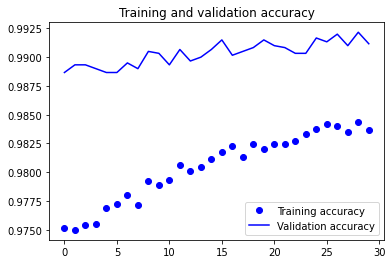

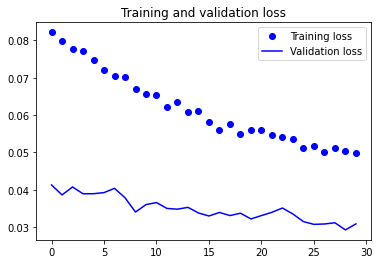

In [ ]:
print(history.history.keys())
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']


plt.plot(list(range(epochs)), train_accuracy, 'bo', label = 'Training accuracy')
plt.plot(list(range(epochs)), val_accuracy, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()


plt.figure()
plt.plot(list(range(epochs)), train_loss, 'bo', label = 'Training loss')
plt.plot(list(range(epochs)), val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**ADAM batch_size: 128/epoch: 15** 

Test loss:  0.02647309936583042/Test accuracy:  0.9904999732971191

**SGD batch_size: 64/epoch: 30** 
Test loss:  0.024098893627524376/Test accuracy:  0.9919000267982483

성능이 증가했음을 관찰할 수 있다. 반드시 어떤 optimizer가 좋다고 단정할 수는 없다는 것을 알 수 있다.
overfitting으로 인해 테스트 정확도가 떨어지지 않았음을 알 수 있다.

In [ ]:
score = model.evaluate(x_test, y_test, verbose = 0)
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

Test loss:  0.024098893627524376
Test accuracy:  0.9919000267982483


**결과 plt로 출력**

random 값으로 0-20까지의 idx를 받은 뒤 test한 data들을 5개 출력하는 코드 구성

Image shape: (28, 28, 1)
True Image Label Array: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 
True Image Label Shape: (10,) 
True Image Label: 7


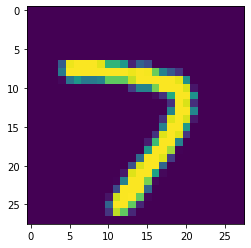

Predicted Image Label Array: ['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '1.000', '0.000', '0.000'] 
Predicted Image Label Shape: (1, 10) 
Predicted iMage Label: 7
Image shape: (28, 28, 1)
True Image Label Array: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 
True Image Label Shape: (10,) 
True Image Label: 1


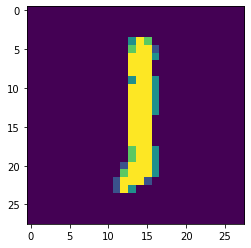

Predicted Image Label Array: ['0.000', '1.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000'] 
Predicted Image Label Shape: (1, 10) 
Predicted iMage Label: 1
Image shape: (28, 28, 1)
True Image Label Array: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
True Image Label Shape: (10,) 
True Image Label: 0


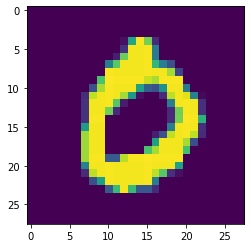

Predicted Image Label Array: ['1.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000'] 
Predicted Image Label Shape: (1, 10) 
Predicted iMage Label: 0
Image shape: (28, 28, 1)
True Image Label Array: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 
True Image Label Shape: (10,) 
True Image Label: 4


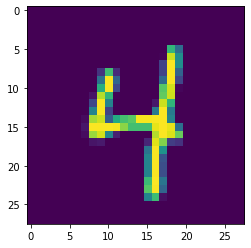

Predicted Image Label Array: ['0.000', '0.000', '0.000', '0.000', '1.000', '0.000', '0.000', '0.000', '0.000', '0.000'] 
Predicted Image Label Shape: (1, 10) 
Predicted iMage Label: 4
Image shape: (28, 28, 1)
True Image Label Array: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
True Image Label Shape: (10,) 
True Image Label: 0


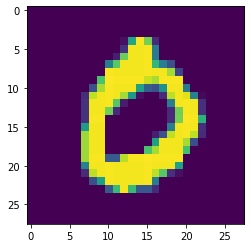

Predicted Image Label Array: ['1.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000'] 
Predicted Image Label Shape: (1, 10) 
Predicted iMage Label: 0


In [ ]:
import random
for i in range(5):
  # img_id = 0
  img_id = random.randint(0, 20)
  sample_test_image = x_test[img_id]
  sample_test_label = y_test[img_id]

  print('Image shape:', sample_test_image.shape)
  print('True Image Label Array:', sample_test_label,
        '\nTrue Image Label Shape:', sample_test_label.shape,
        '\nTrue Image Label:', np.argmax(sample_test_label))
  plt.imshow(sample_test_image.reshape(28,28), interpolation = 'nearest')
  plt.show()

  prediction = model.predict(sample_test_image.reshape(1,28,28,1))

  print('Predicted Image Label Array:', ['{0:0.3f}'.format(i) for i in prediction[0]],
        '\nPredicted Image Label Shape:', prediction.shape,
        '\nPredicted iMage Label:', np.argmax(prediction))
